# 画像からキャプションを生成してみよう

## 目次
- Section 4 実装②
    - CNN-LSTM with Attention

## Section 4 実装②

ここでは, Section 3で学んだ知識を使って, AttentionつきのCNN-LSTMを実装し, 改めてMS-COCOデータセットでキャプション生成を行いましょう.

### 4.0 データの準備

In [1]:
# ファイルサイズが大きいので少し時間がかかります

import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

def load_data(file_path, tokenizer = None):
    whole_texts = []
    for line in open(file_path, encoding='utf-8'):
        whole_texts.append("<s> " + line.strip() + " </s>")
        
    if tokenizer == None :
        tokenizer = Tokenizer(filters="")
        tokenizer.fit_on_texts(whole_texts)
    
    return tokenizer.texts_to_sequences(whole_texts), tokenizer

x_train = np.load('/root/userspace/public/lesson5/data/mscoco_images_9000.npy')
x_valid = np.load('/root/userspace/public/lesson5/data/mscoco_images_1000.npy')

# 読み込み＆Tokenizerによる数値化
y_train, tokenizer_train = load_data('/root/userspace/public/lesson5/data/mscoco_captions_9000.txt')
y_valid, _ = load_data('/root/userspace/public/lesson5/data/mscoco_captions_1000.txt', tokenizer_train)

vocab_size = len(tokenizer_train.word_index) + 1

# パディング
y_train = pad_sequences(y_train, padding='post')
y_valid = pad_sequences(y_valid, padding='post')

caption_len = len(y_train[0])

Using TensorFlow backend.


### 4.1 モデル構築

#### Encoder

In [2]:
from keras import backend as K
from keras.layers import Input, Flatten, Lambda
from keras.applications.vgg16 import VGG16

K.clear_session()

encoder_input = Input(shape=(224, 224, 3))
encoder_input_normalized = Lambda(lambda x: x / 255.)(encoder_input) # [0, 255) -> [0, 1)
encoder = VGG16(weights='imagenet', include_top=False, input_tensor=encoder_input_normalized)

# パラメータを固定
for layer in encoder.layers:
    layer.trainable = False

# CNNの出力
u = Flatten()(encoder.output)

#### Decoder

In [3]:
from keras.layers import Dense, Embedding, LSTM

emb_dim = 128
hid_dim = 128

# LSTMの初期状態
decoded_states = [Dense(hid_dim)(u), Dense(hid_dim)(u)] # h_0, c_0 に対応

# 層の定義
decoder_input = Input(shape=(caption_len,))
embedding = Embedding(vocab_size, emb_dim, mask_zero=True)
lstm = LSTM(hid_dim, activation='tanh', return_sequences=True, return_state=True)

# 層の接続
decoder_embedded = embedding(decoder_input)
decoder_output, _, _ = lstm(decoder_embedded, initial_state=decoded_states) # 第2,3戻り値(最終ステップのh, c)は無視

#### Attention

In [4]:
from keras.layers import Reshape, Activation, concatenate, dot

# 0. reshape: (7, 7, 512) -> (49, 512)
u_map = Reshape((7*7, 512))(u)

# 1. スコアの計算
dense_att = Dense(hid_dim)
score = dot([decoder_output, dense_att(u_map)], axes=-1)

# 2. 重みの計算
attention = Activation('softmax')(score)

# 3. 文脈ベクトルの計算
context = dot([attention, u_map], axes=(2,1))

# 4. 出力ベクトルの計算
attention_dense = Dense(hid_dim, activation='tanh')
output_dense = Dense(vocab_size, activation='softmax')
concat = concatenate([context, decoder_output], axis=2)
attentional = attention_dense(concat)
y_pred = output_dense(attentional)

#### model化

In [5]:
from keras.models import Model

model = Model([encoder_input, decoder_input], y_pred)
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

### 2.2 モデルの学習

In [6]:
import numpy as np

train_target = np.hstack((y_train[:, 1:], np.zeros((len(y_train),1), dtype=np.int32)))

model.fit([x_train, y_train], np.expand_dims(train_target, -1), batch_size=64, epochs=10, verbose=1, validation_split=0.2)

Train on 7200 samples, validate on 1800 samples
Epoch 1/10
7200/7200 [==============================] - 282s 39ms/step - loss: 5.0100 - val_loss: 4.4430
Epoch 2/10
7200/7200 [==============================] - 247s 34ms/step - loss: 4.0392 - val_loss: 3.8417
Epoch 3/10
7200/7200 [==============================] - 247s 34ms/step - loss: 3.5911 - val_loss: 3.6127
Epoch 4/10
7200/7200 [==============================] - 246s 34ms/step - loss: 3.3706 - val_loss: 3.4638
Epoch 5/10
7200/7200 [==============================] - 246s 34ms/step - loss: 3.2130 - val_loss: 3.3771
Epoch 6/10
7200/7200 [==============================] - 246s 34ms/step - loss: 3.0962 - val_loss: 3.2927
Epoch 7/10
7200/7200 [==============================] - 246s 34ms/step - loss: 2.9971 - val_loss: 3.2576
Epoch 8/10
7200/7200 [==============================] - 246s 34ms/step - loss: 2.9051 - val_loss: 3.2038
Epoch 9/10
7200/7200 [==============================] - 246s 34ms/step - loss: 2.8220 - val_loss: 3.1647
Epoch 1

### 2.3 モデルによる生成

In [7]:
encoder_model = Model(encoder_input, [u_map]+decoded_states)

decoder_states_inputs = [Input(shape=(hid_dim,)), Input(shape=(hid_dim,))]

decoder_input = Input(shape=(1,))
decoder_embeded = embedding(decoder_input)
decoded_seq, *decoder_states = lstm(decoder_embeded, initial_state=decoder_states_inputs)

decoder_model = Model([decoder_input] + decoder_states_inputs, [decoded_seq] + decoder_states)

# Attention
u_map_in, decoded_seq_in = Input(shape=(7*7, 512)), Input(shape=(1, hid_dim))
score = dot([decoded_seq_in, dense_att(u_map_in)], axes=-1)
attention = Activation('softmax')(score)
context = dot([attention, u_map_in], axes=(2,1))
concat = concatenate([context, decoded_seq_in], axis=2)
attentional = attention_dense(concat)
attention_outputs = output_dense(attentional)

attention_model = Model([u_map_in, decoded_seq_in], [attention_outputs, attention])

#### Beam Search

In [8]:
# logの中身が0になるのを防ぐ
def np_log(x):
    return np.log(np.clip(x, 1e-10, x))

In [9]:
import sys
sys.path.append('/root/userspace/public/lesson5/master')

In [10]:
import copy
from utils import Node

def beam_search(input_image, bos_eos, K=5, max_output_length = 100):
    u_map, *states = encoder_model.predict(input_image)
    
    # [score, y_pred, attention, states_tm1]
    candidates = [[0, np.array(bos_eos[0]), np.empty((0, 7*7)), states]]
    root = Node(bos_eos[0][0])
        
    t = 0
    while t < max_output_length:
        t += 1
        
        # すべての候補を一時的に保管するリスト
        tmp_candidates = []
        
        # </s>がすべての候補で出力されたかどうかのフラッグ
        end_flag = True
        for score_sum, y_pred, attention_seq, states_prev in candidates:
            attention_seq = copy.deepcopy(attention_seq)
            if y_pred[-1] == bos_eos[1]:
                tmp_candidates.append([score_sum, y_pred, attention_seq, states_prev])
            else:
                end_flag = False
                decoded_seq, *states = decoder_model.predict([y_pred[-1:]] + states_prev)
                token_dist, attention = attention_model.predict([u_map, decoded_seq])
                
                # 確率の高い単語（＝対数尤度の高い単語）とそのidを取得（上位K個）
                y_loglikelihood = np_log(token_dist.flatten())
                y_t, s_t = np.argsort(y_loglikelihood)[::-1][:K], np.sort(y_loglikelihood)[::-1][:K] # argsortは昇順なので反転
                
                # スコア (対数尤度) を蓄積（s_core_tm1はスカラー, s_tはベクトル）
                s_t = s_t + score_sum
                
                # すべての候補を一時的に保管
                tmp_candidates.extend(
                    [[s_tk, np.append(y_pred, [y_tk]), np.append(attention_seq, [attention.flatten()], axis=0), states] for s_tk, y_tk in zip(s_t, y_t)]
                )
        if end_flag:
            break
        
        # 正規化したスコアでソートし, 上位K個の候補を保存 ()
        candidates = sorted(tmp_candidates, key=lambda x: x[0]/len(x[1]), reverse=True)[:K]
        
        # Beam Search可視化用
        root.depth += 1
        for _, y_pred, _, _ in candidates:
            root.add_child(y_pred)
    
    # 最もスコアの高い候補を返す
    return candidates[0][1], root, candidates[0][2]

参考までに, 通常の貪欲decoding関数の関数は次のようになります.

In [11]:
def decode_sequence(input_image, bos_eos, max_output_length = 100):
    u_map, *states = encoder_model.predict(input_image)

    target_seq = np.array(bos_eos[0])  # bos_eos[0]="<s>"に対応するインデックス
    output_seq = bos_eos[0]
    attention_seq = np.empty((0, 7*7))
    
    while True:
        decoded_seq, *states = decoder_model.predict([target_seq] + states)
        token_dist, attention = attention_model.predict([u_map, decoded_seq])
        sampled_token_index = [np.argmax(token_dist[0, -1, :])]
        output_seq += sampled_token_index
        attention_seq = np.append(attention_seq, [attention.flatten()], axis=0)
        
        if (sampled_token_index == bos_eos[1] or len(output_seq) > max_output_length):
            break

        target_seq = np.array(sampled_token_index)

    return output_seq, attention_seq

<s> a person on a surfboard in the air . </s>


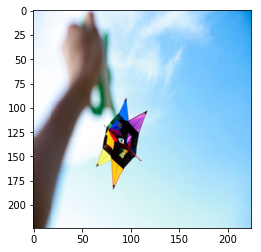

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

test_no = 100

bos_eos = tokenizer_train.texts_to_sequences(["<s>", "</s>"])
detokenizer_train = dict(map(reversed, tokenizer_train.word_index.items()))

x_test = np.array(x_valid[test_no:test_no+1])

y_pred, root, att_a= beam_search(x_test, bos_eos, K=3, max_output_length=25)
#y_pred, att_a= decode_sequence(x_test, bos_eos, max_output_length=25)

print(' '.join([detokenizer_train[i] for i in y_pred]))

plt.imshow(x_test[0])

ここではさらに、Attentionの分布も描画してみましょう。

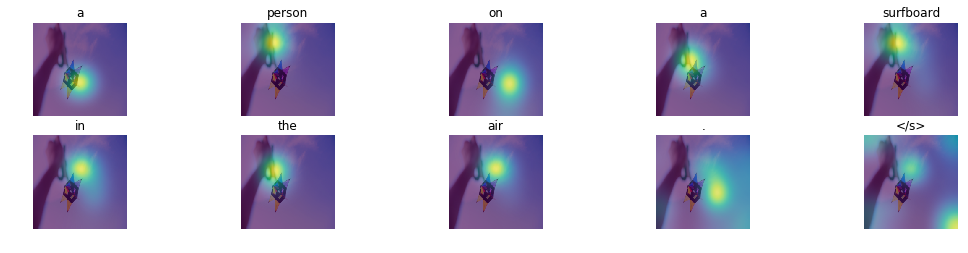

In [13]:
import skimage.transform

fig = plt.figure(figsize=(18, 10))

for i, (wordid, att_a_t) in enumerate(zip(y_pred[1:], att_a)):
    ax = fig.add_subplot(5, 5, i+1)
    
    # Plot image
    ax.imshow(x_test[0])
    ax.axis('off')
    
    # Plot attention
    att_a_t = skimage.transform.pyramid_expand(att_a_t.reshape(7, 7), upscale=32, sigma=20)
    ax.imshow(att_a_t, alpha=.65)
    # Plot word
    ax.set_title(detokenizer_train[wordid])

plt.show()

また次のようにbeam searchの過程を可視化できます。

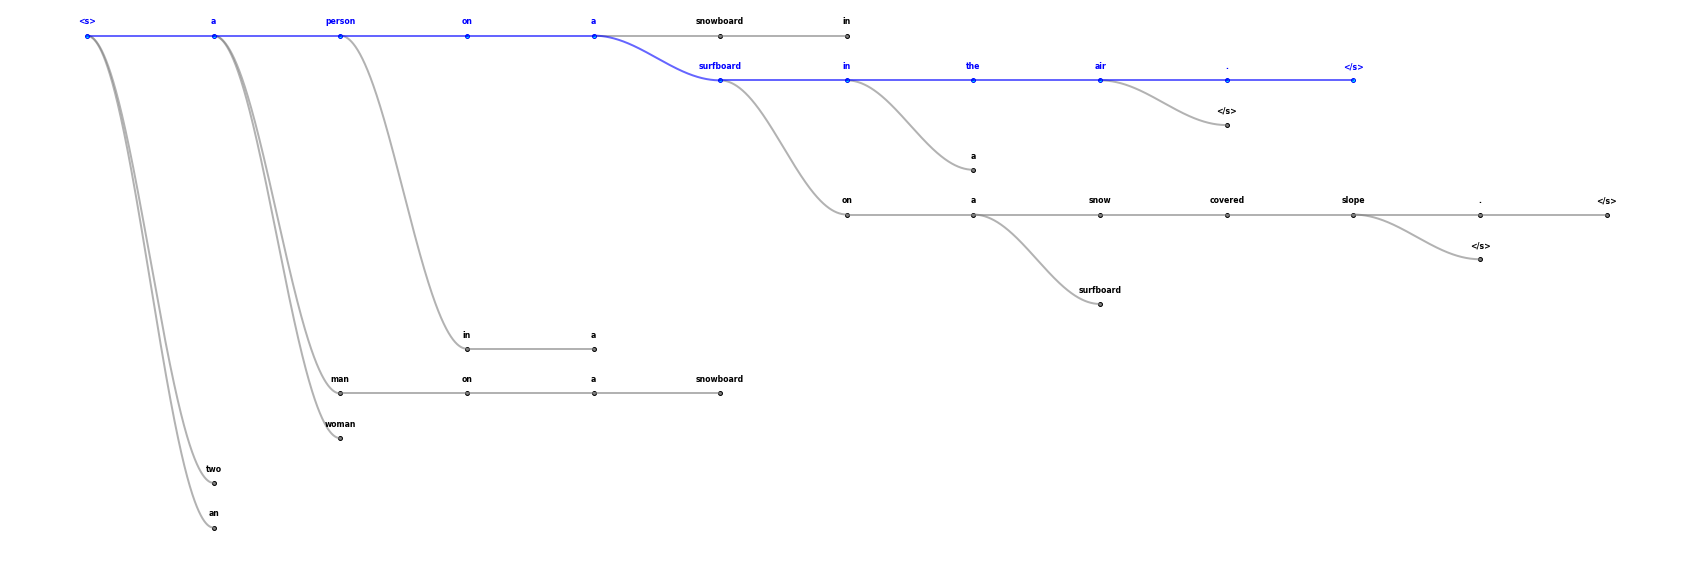

In [14]:
fig = plt.figure(figsize=(30, 10))

ax = fig.add_subplot(111, xticks=[], yticks=[])
ax.axis('off')

root.mark_best_path(y_pred)

root.set_coordinates(0, 0, ax, detokenizer_train, tree_depth=root.depth)

plt.show()